<a href="https://colab.research.google.com/github/rajprashant84/CF969_Big_Data_for_Computational_Finance/blob/main/Labs_6_7_TensorFlow_on_Financial_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Labs 6-7: TensorFlow with Financial Data

Today, we have more data at our disposal than ever, more sources of data, and more frequent delivery of that data. New sources include new exchanges, social media outlets, and news sources. Naturally, more and different analysis techniques are being brought to bear as a result. Most of the modern analysis techniques aren't different in the sense of being new, and they all have their basis in statistics, but their applicability has closely followed the amount of computing power available. The growth in available computing power is faster than the growth in time series volumes, so it is possible to analyze time series today at scale in ways that weren't previously practical.

In particular, machine learning techniques, especially deep learning, hold promise for time series analysis. As time series become more dense and many time series overlap, machine learning offers a way to separate the signal from the noise, even when the noise can seem overwhelming. Deep learning holds potential because it is often a good fit for the seemingly random nature of financial time series.

In this notebook, we will first obtain data for a number of financial markets. We will then transform the data into a usable format and perform exploratory data analysis in order to explore and validate a hypothesis. Then, we will use Tensorflow to build, train and evaluate a number of models for predicting what will happen in financial markets

<h3>The working hypothesis</h3>
Our thinking is as follows: financial markets are increasingly global, and if we follow the sun from Asia to Europe to the US and so on, we can use information from an earlier time zone to our advantage in a later time zone.
The following table shows a number of stock market indices from around the globe, their closing times in Eastern Standard Time (EST), and the delay in hours between the close that index and the close of the S&P 500 in New York. This makes EST the base time zone. For example, Australian markets close for the day 15 hours before US markets close. If the close of the All Ords in Australia is a useful predictor of the close of the S&P 500 for a given day we can use that information to guide our trading activity. Continuing our example of the Australian All Ords, if this index closes up and we think that means the S&P 500 will close up as well then we should either buy stocks that compose the S&P 500 or, more likely, an ETF that tracks the S&P 500. In reality, the situation is more complex because there are commissions and tax to account for. But as a first approximation, we'll assume an index closing up indicates a gain, and vice-versa.

<table>
<tr><th>Index</th><th>Country</th>	<th>Closing Time (EST)</th>	<th>Hours Before S&P Close</th></tr>
<tr><td>All Ords</td><td>Australia</td>	<td>0100</td>	<td>15</td></tr>
<tr><td>Nikkei 225</td><td>Japan</td>	<td>0200</td>	<td>14</td></tr>
<tr><td>Hang Seng</td><td>Hong Kong</td>	<td>0400</td>	<td>12</td></tr>
<tr><td>DAX</td><td>Germany</td>	<td>1130</td>	<td>4.5</td></tr>
<tr><td>FTSE 100</td><td>UK</td>	<td>1130</td>	<td>4.5</td></tr>
<tr><td>NYSE Composite</td><td>US</td>	<td>1600</td>	<td>0</td></tr>
<tr><td>Dow Jones Industrial Average</td><td>US</td>	<td>1600</td>	<td>0</td></tr>
<tr><td>S&P 500</td><td>US</td>	<td>1600</td>	<td>0</td></tr>
</table>

<h3>Set up</h3>
First, we will import some necessary libraries. We have already discussed numpy, pandas, tensorflow, and matplotlib.

In [1]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas.plotting import scatter_matrix

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%pylab inline

Populating the interactive namespace from numpy and matplotlib


<h3>Get the data</h3>
The data covers the new millenium (2000 onwards) and is available in the data directory. Data comes from the S&P 500 (S&P), NYSE, Dow Jones Industrial Average (DJIA), Nikkei 225 (Nikkei), Hang Seng, FTSE 100 (FTSE), DAX, and All Ordinaries (AORD) indices. 

We access this data as Pandas DataFrames.

In [2]:
#Reading the datasets in different dataframes using Pandas

snp = pd.read_csv("/content/YAHOO-INDEX_GSPC.csv", index_col='Date')
nyse = pd.read_csv("/content/YAHOO-INDEX_NYA.csv", index_col='Date') 
djia = pd.read_csv("/content/YAHOO-INDEX_DJI.csv", index_col='Date') 
nikkei = pd.read_csv("/content/YAHOO-INDEX_N225.csv", index_col='Date') 
hangseng = pd.read_csv("/content/YAHOO-INDEX_HSI.csv", index_col='Date') 
ftse = pd.read_csv("/content/FTSE100.csv", index_col='Date') 
dax = pd.read_csv("/content/YAHOO-INDEX_GDAXI.csv", index_col='Date') 
aord = pd.read_csv("/content/YAHOO-INDEX_AORD.csv", index_col='Date')

<h3>Munge the data</h3>
In the first instance, munging the data is straightforward. The closing prices are of interest, so for convenience extract the closing prices for each of the indices into a single Pandas DataFrame, called <i>closing_data</i>. Because not all of the indices have the same number of values, mainly due to bank holidays, we'll fill the gaps. This means that, if a value isn't available for day $N$, fill it with the value for another day, such as $N+1$ or $N+2$.

In [3]:
closing_data = pd.DataFrame()

closing_data['snp_close'] = snp['Close']
closing_data['nyse_close'] = nyse['Close']
closing_data['djia_close'] = djia['Close']
closing_data['nikkei_close'] = nikkei['Close']
closing_data['hangseng_close'] = hangseng['Close']
closing_data['ftse_close'] = ftse['Close']
closing_data['dax_close'] = dax['Close']
closing_data['aord_close'] = aord['Close']

# Pandas includes a very convenient function for filling gaps in the data.
closing_data = closing_data.fillna(method='bfill')

At this point, we have sourced some years of time series for eight financial indices, combined the data into a single data structure, and harmonized the data to have the same number of entries, by using only the 20 lines of code in this notebook. 

<h3>Exploratory data analysis</h3>
Exploratory Data Analysis (EDA) is foundational to working with machine learning, and any other sort of analysis. EDA means getting to know our data, so that when we build models, we build them based on an actual, physical understanding of the data, and not on assumptions. We can still make assumptions of course, but EDA means we will understand our assumptions and why we are making those assumptions. 

First, take a look at the data.

In [4]:
closing_data.describe()

,snp_close,nyse_close,djia_close,nikkei_close,hangseng_close,ftse_close,dax_close,aord_close
count,5283.000000,5283.000000,5283.000000,5283.000000,5283.000000,5283.000000,5283.000000,5283.000000
mean,1653.271474,8790.468885,14652.944923,14645.094467,19932.602458,5902.126034,7674.761376,4788.373252
std,673.836019,2422.444609,5789.456707,4691.973641,5721.189204,1003.713640,3009.904238,1126.980000
min,676.530029,4226.310059,6547.049805,7054.979980,8409.009766,3287.000000,2202.959961,2673.300049
25%,1163.349976,6813.219971,10456.114745,10399.284670,14989.035155,5238.050000,5383.854981,3727.550049
50%,1386.949951,8314.299805,12337.219730,14258.040040,20955.250000,5976.000000,6982.450195,4910.100098
75%,2071.239991,10707.750000,17730.495120,18163.274415,23844.785160,6623.800000,10209.220215,5671.949951
max,3735.360107,14516.730470,30409.560550,27568.150390,33154.121090,7877.500000,13790.290040,7255.200195


We can see that the various indices operate on scales differing by orders of magnitude. It is best to scale the data so that, for example, operations involving multiple indices aren't unduly influenced by a single, massive index.

Let's first plot the data.

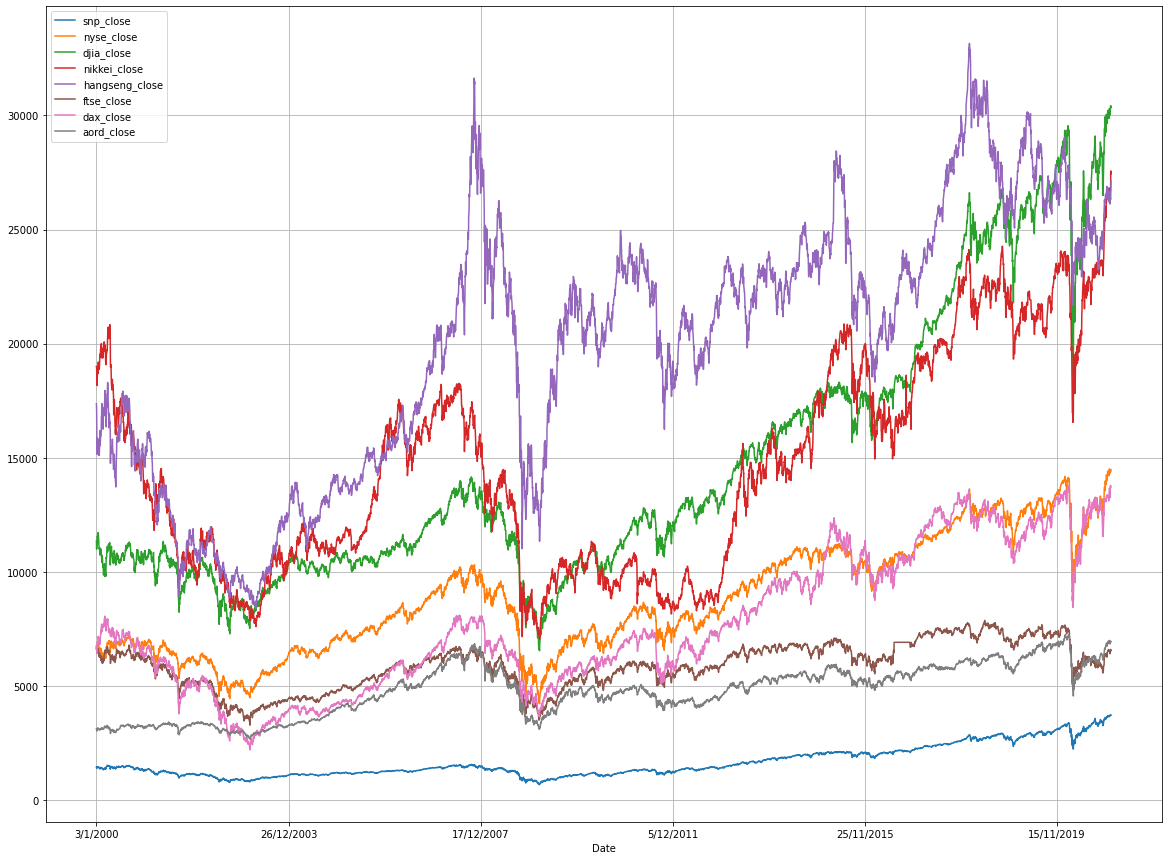

In [5]:
plot_frame = pd.DataFrame()

plot_frame = pd.concat([closing_data['snp_close'],
  closing_data['nyse_close'],
  closing_data['djia_close'],
  closing_data['nikkei_close'],
  closing_data['hangseng_close'],
  closing_data['ftse_close'],
  closing_data['dax_close'],
  closing_data['aord_close']], axis=1)
plot_frame.plot(figsize=(20, 15), grid=True)

As expected, the structure isn't entirely visible for all indices. Notice that there is an index ranging below $5\, 000$ while other indices range from $20\, 000$ to $30\, 000$. So, let's divide each value in an individual index by the maximum value for that index, and then replot. The maximum value of all indices will then be 1.

In [6]:
closing_data['snp_close_scaled'] = closing_data['snp_close'] / max(closing_data['snp_close'])
closing_data['nyse_close_scaled'] = closing_data['nyse_close'] / max(closing_data['nyse_close'])
closing_data['djia_close_scaled'] = closing_data['djia_close'] / max(closing_data['djia_close'])
closing_data['nikkei_close_scaled'] = closing_data['nikkei_close'] / max(closing_data['nikkei_close'])
closing_data['hangseng_close_scaled'] = closing_data['hangseng_close'] / max(closing_data['hangseng_close'])
closing_data['ftse_close_scaled'] = closing_data['ftse_close'] / max(closing_data['ftse_close'])
closing_data['dax_close_scaled'] = closing_data['dax_close'] / max(closing_data['dax_close'])
closing_data['aord_close_scaled'] = closing_data['aord_close'] / max(closing_data['aord_close'])

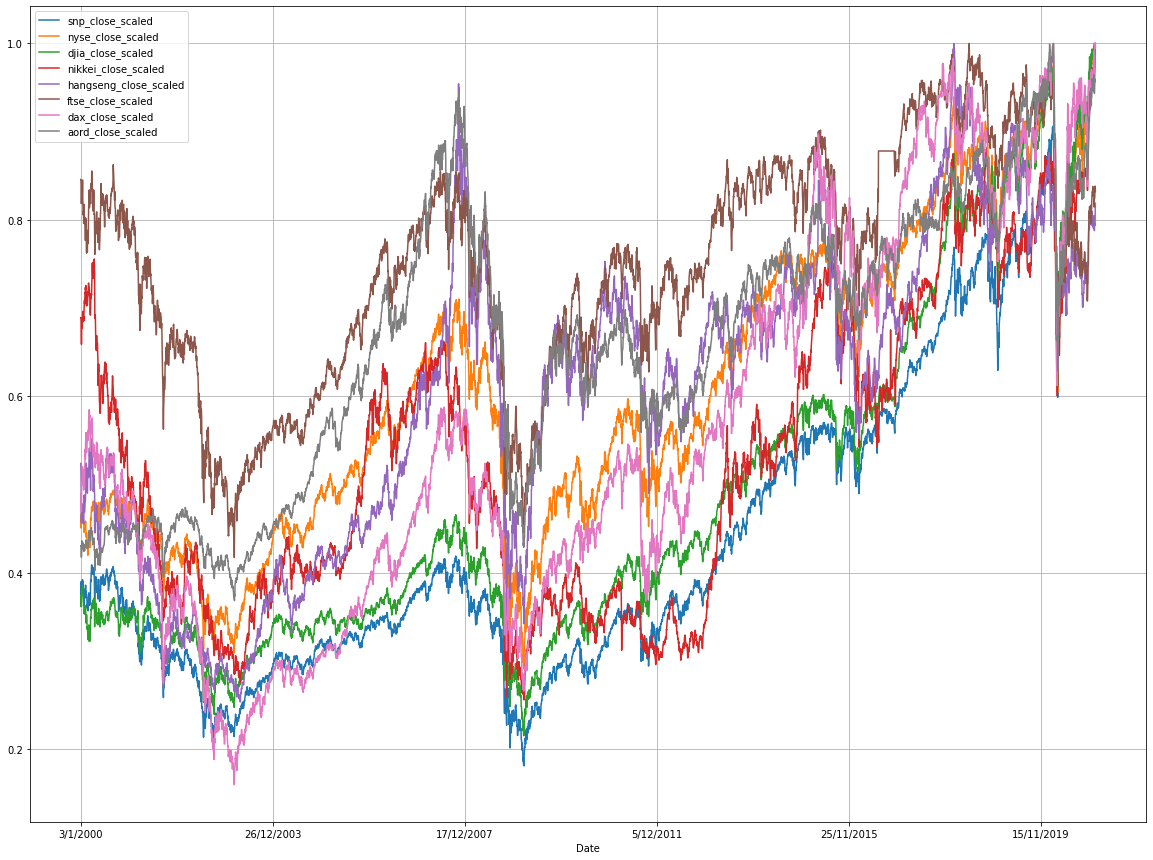

In [7]:
_ = pd.concat([closing_data['snp_close_scaled'],
  closing_data['nyse_close_scaled'],
  closing_data['djia_close_scaled'],
  closing_data['nikkei_close_scaled'],
  closing_data['hangseng_close_scaled'],
  closing_data['ftse_close_scaled'],
  closing_data['dax_close_scaled'],
  closing_data['aord_close_scaled']], axis=1).plot(figsize=(20, 15), grid=True)

We see that, over the period of interest, these indices are correlated. Notice that sudden drops from economic events happened globally to all indices, and they otherwise exhibited general rises. This is a good start, though not the complete story. 

Now, we plot [autocorrelations](https://en.wikipedia.org/wiki/Autocorrelation) for each of the indices. The autocorrelations determine correlations between current values of the index and lagged values of the same index. The goal is to determine whether the lagged values are reliable indicators of the current values. If they are, then we've identified a correlation.

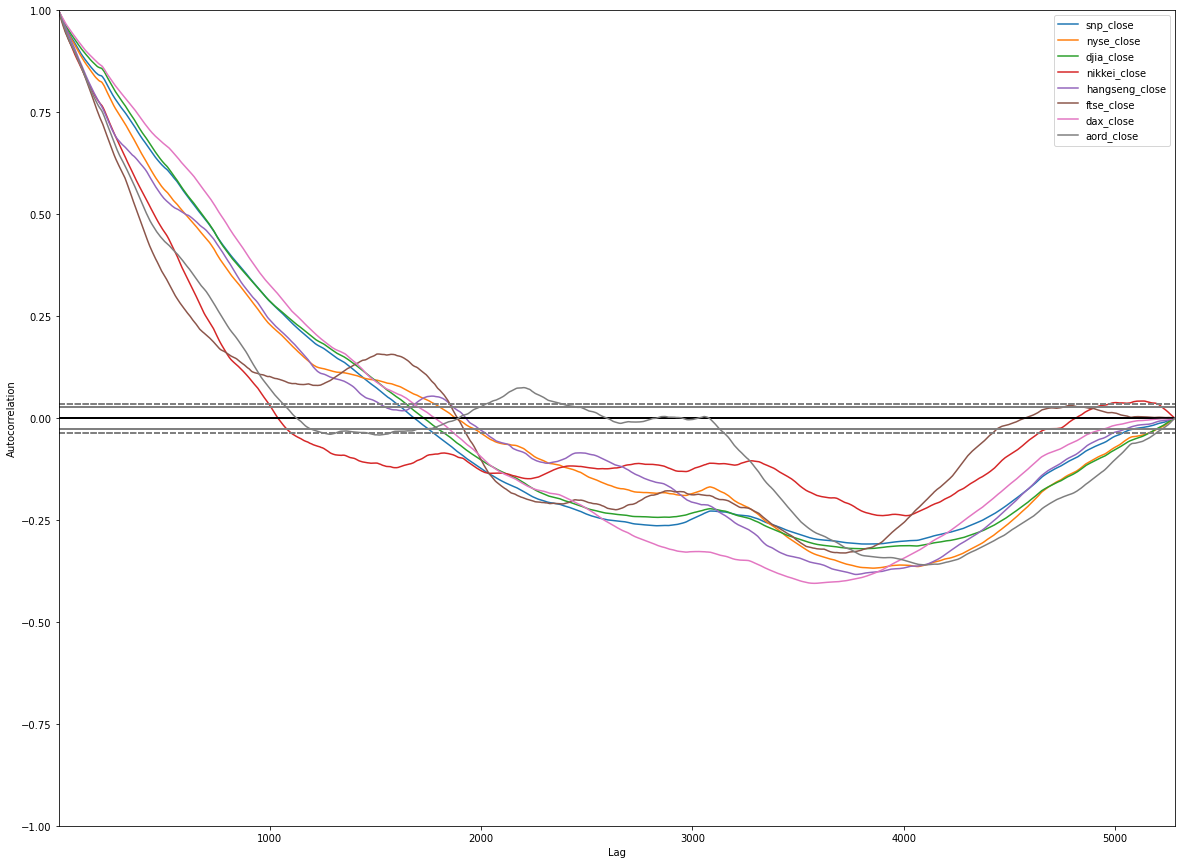

In [8]:
fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(15)

_ = autocorrelation_plot(closing_data['snp_close'], label='snp_close')
_ = autocorrelation_plot(closing_data['nyse_close'], label='nyse_close')
_ = autocorrelation_plot(closing_data['djia_close'], label='djia_close')
_ = autocorrelation_plot(closing_data['nikkei_close'], label='nikkei_close')
_ = autocorrelation_plot(closing_data['hangseng_close'], label='hangseng_close')
_ = autocorrelation_plot(closing_data['ftse_close'], label='ftse_close')
_ = autocorrelation_plot(closing_data['dax_close'], label='dax_close')
_ = autocorrelation_plot(closing_data['aord_close'], label='aord_close')

_ = plt.legend(loc='upper right')

We see some strong autocorrelations, both positive and negative for several days. This tells us something we perhaps intuitively expect: if an index is rising it tends to carry on rising, and vice-versa. It should be encouraging that what we see here conforms to what we know about financial markets.

Next, look at a scatter matrix, showing everything plotted against everything, to see how indices are correlated with each other.

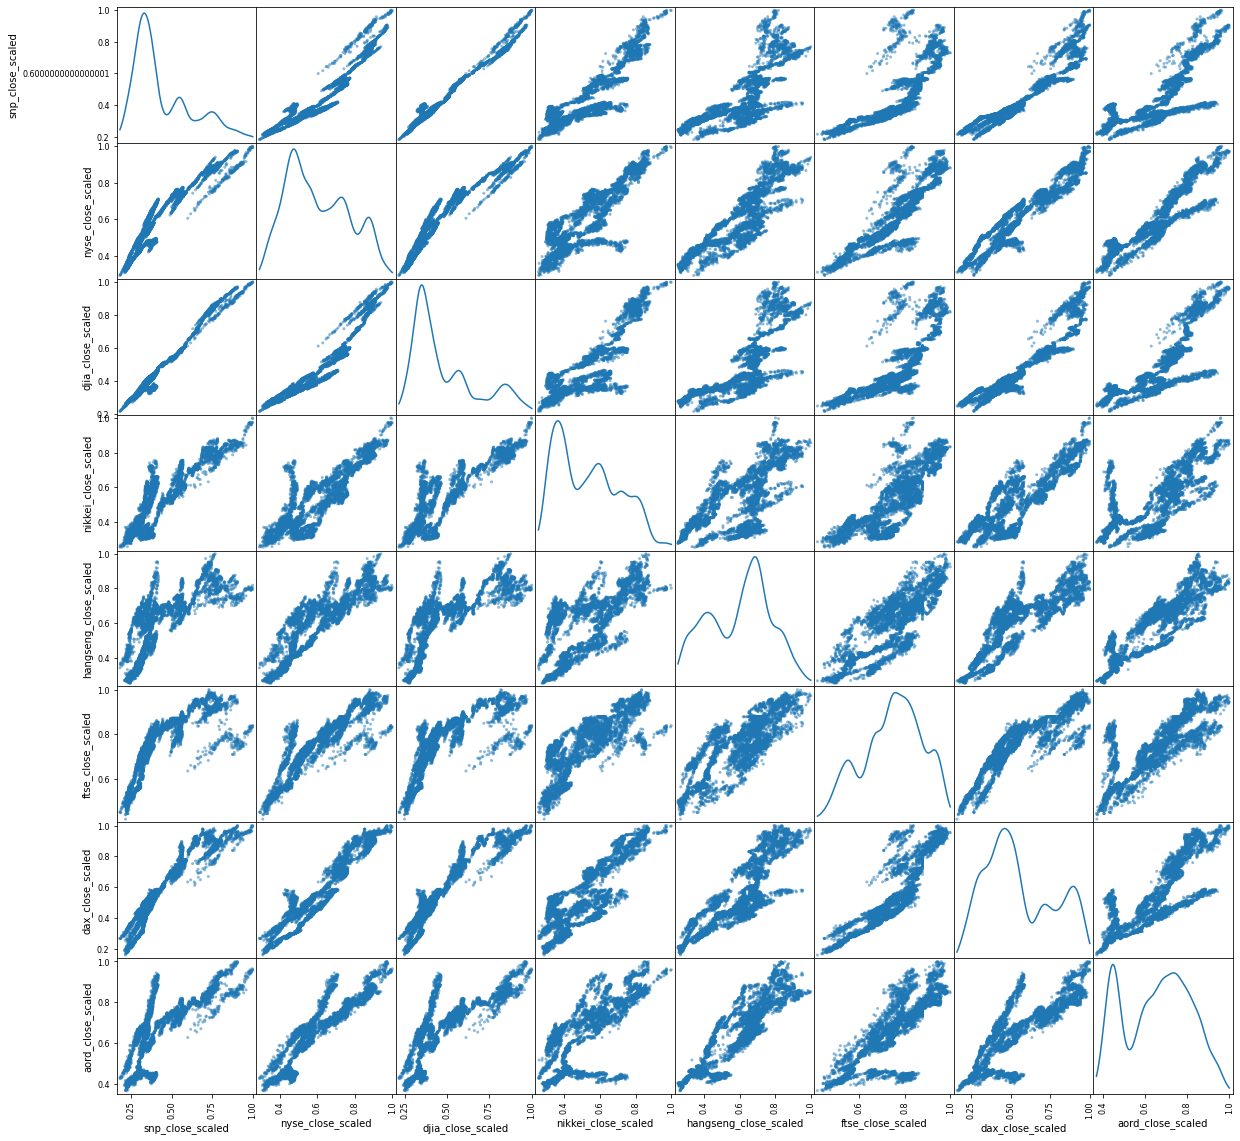

In [9]:
plot_frame=pd.concat([closing_data['snp_close_scaled'],
  closing_data['nyse_close_scaled'],
  closing_data['djia_close_scaled'],
  closing_data['nikkei_close_scaled'],
  closing_data['hangseng_close_scaled'],
  closing_data['ftse_close_scaled'],
  closing_data['dax_close_scaled'],
  closing_data['aord_close_scaled']], axis=1)
_ = scatter_matrix(plot_frame, figsize=(20, 20), diagonal='kde')
#plot_frame.describe()

We can see significant correlations across the board, further evidence that the working hypothesis is sound and one market can be influenced by another. 

The actual value of an index is not that useful for modeling. It can be a useful indicator, but to get to the heart of the matter, we need a time series that is stationary in the mean, thus having no trend in the data. There are various ways of doing that, but they all essentially look at the difference between values, rather than the absolute value. In the case of market data, the usual practice is to work with logged returns, calculated as the natural logarithm of the index today divided by the index yesterday:

$$ln\left(\frac{V_t}{V_{t-1}}\right)$$

There are more reasons why the log return is preferable to the percent return (for example the log is normally distributed and additive), but they don't matter much for this work. What matters is to get to a stationary time series. Let's calculate and plot the log returns in a new DataFrame.

In [10]:
log_return_data = pd.DataFrame()

log_return_data['snp_log_return'] = np.log(closing_data['snp_close']/closing_data['snp_close'].shift())
log_return_data['nyse_log_return'] = np.log(closing_data['nyse_close']/closing_data['nyse_close'].shift())
log_return_data['djia_log_return'] = np.log(closing_data['djia_close']/closing_data['djia_close'].shift())
log_return_data['nikkei_log_return'] = np.log(closing_data['nikkei_close']/closing_data['nikkei_close'].shift())
log_return_data['hangseng_log_return'] = np.log(closing_data['hangseng_close']/closing_data['hangseng_close'].shift())
log_return_data['ftse_log_return'] = np.log(closing_data['ftse_close']/closing_data['ftse_close'].shift())
log_return_data['dax_log_return'] = np.log(closing_data['dax_close']/closing_data['dax_close'].shift())
log_return_data['aord_log_return'] = np.log(closing_data['aord_close']/closing_data['aord_close'].shift())

log_return_data.describe()

,snp_log_return,nyse_log_return,djia_log_return,nikkei_log_return,hangseng_log_return,ftse_log_return,dax_log_return,aord_log_return
count,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000
mean,0.000178,0.000144,0.000186,0.000070,0.000085,-0.000003,0.000134,0.000151
std,0.012554,0.012466,0.012079,0.014837,0.014511,0.011971,0.014997,0.010116
min,-0.127652,-0.125950,-0.138418,-0.121110,-0.146954,-0.115117,-0.130549,-0.104874
25%,-0.004771,-0.004658,-0.004614,-0.006605,-0.006296,-0.005264,-0.006601,-0.004273
50%,0.000594,0.000632,0.000506,0.000000,0.000000,0.000025,0.000572,0.000407
75%,0.005803,0.005686,0.005588,0.007498,0.007038,0.005741,0.007388,0.005227
max,0.109572,0.115258,0.107643,0.132346,0.134068,0.093842,0.107975,0.063548


Looking at the log returns, you should see that the mean, min, max are all similar. You could go further and center the series on zero, scale them, and normalize the standard deviation, but there's no need to do that at this point. Let's move forward with plotting the data, and iterate if necessary.

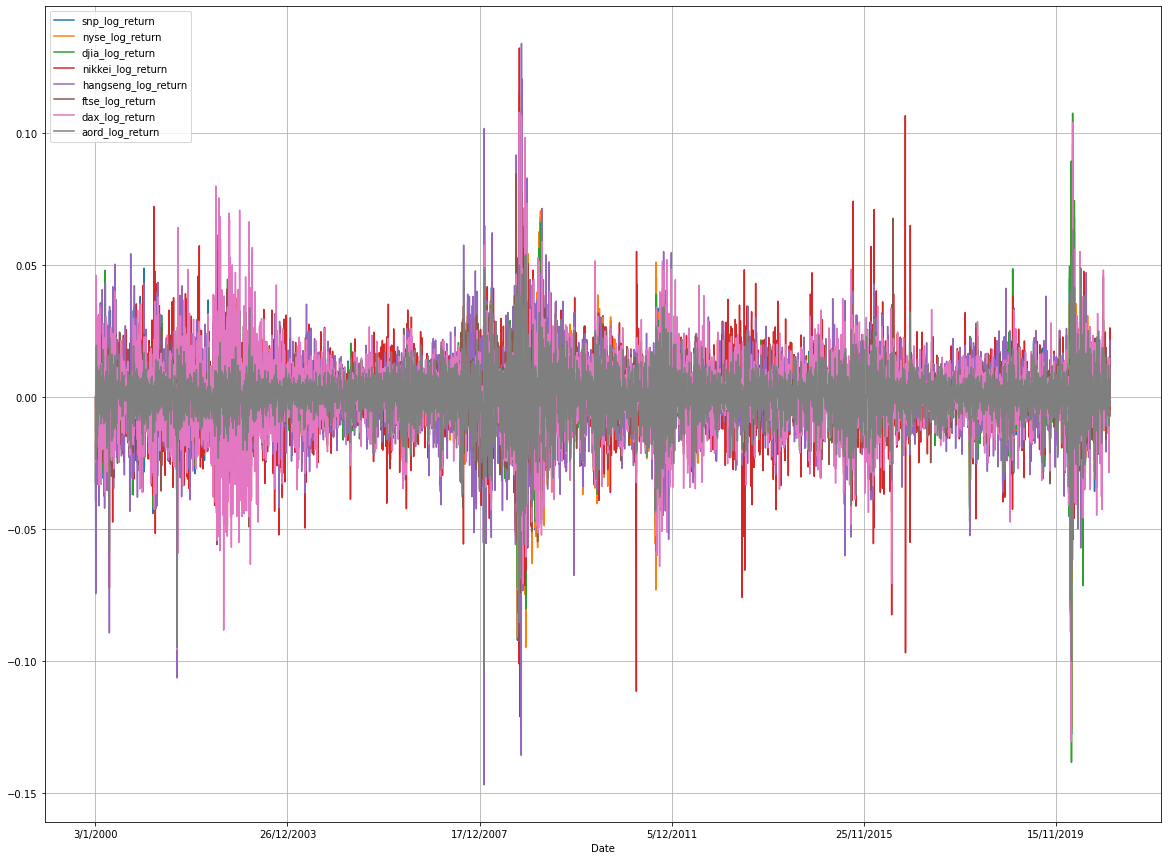

In [11]:
_ = pd.concat([
  log_return_data['snp_log_return'],
  log_return_data['nyse_log_return'],
  log_return_data['djia_log_return'],
  log_return_data['nikkei_log_return'],
  log_return_data['hangseng_log_return'],
  log_return_data['ftse_log_return'],
  log_return_data['dax_log_return'],
  log_return_data['aord_log_return']], axis=1).plot(figsize=(20, 15), grid=True)

We can see from the plot that the log returns of our indices are similarly scaled and centered, with no visible trend in the data. It's looking good, so now look at autocorrelations.

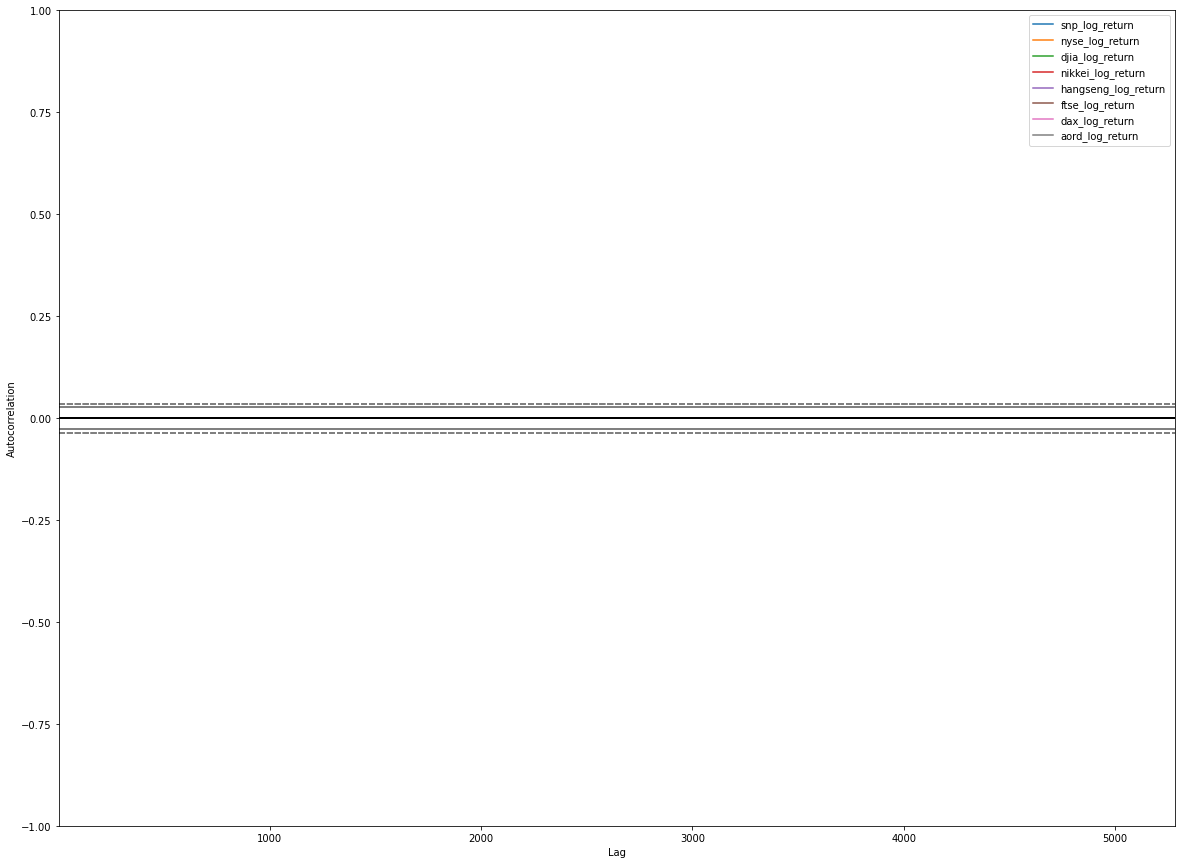

In [12]:
fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(15)

_ = autocorrelation_plot(log_return_data['snp_log_return'], label='snp_log_return')
_ = autocorrelation_plot(log_return_data['nyse_log_return'], label='nyse_log_return')
_ = autocorrelation_plot(log_return_data['djia_log_return'], label='djia_log_return')
_ = autocorrelation_plot(log_return_data['nikkei_log_return'], label='nikkei_log_return')
_ = autocorrelation_plot(log_return_data['hangseng_log_return'], label='hangseng_log_return')
_ = autocorrelation_plot(log_return_data['ftse_log_return'], label='ftse_log_return')
_ = autocorrelation_plot(log_return_data['dax_log_return'], label='dax_log_return')
_ = autocorrelation_plot(log_return_data['aord_log_return'], label='aord_log_return')

_ = plt.legend(loc='upper right')

No autocorrelations are visible in the plot. Individual financial markets are Markov processes and knowledge of history doesn't allow us to predict the future. We now have time series for the indices, stationary in the mean, similarly centered and scaled. 

Now start to look for signals to try to predict the close of the S&P 500. Let's look at a scatterplot to see how the log return indices correlate with each other.

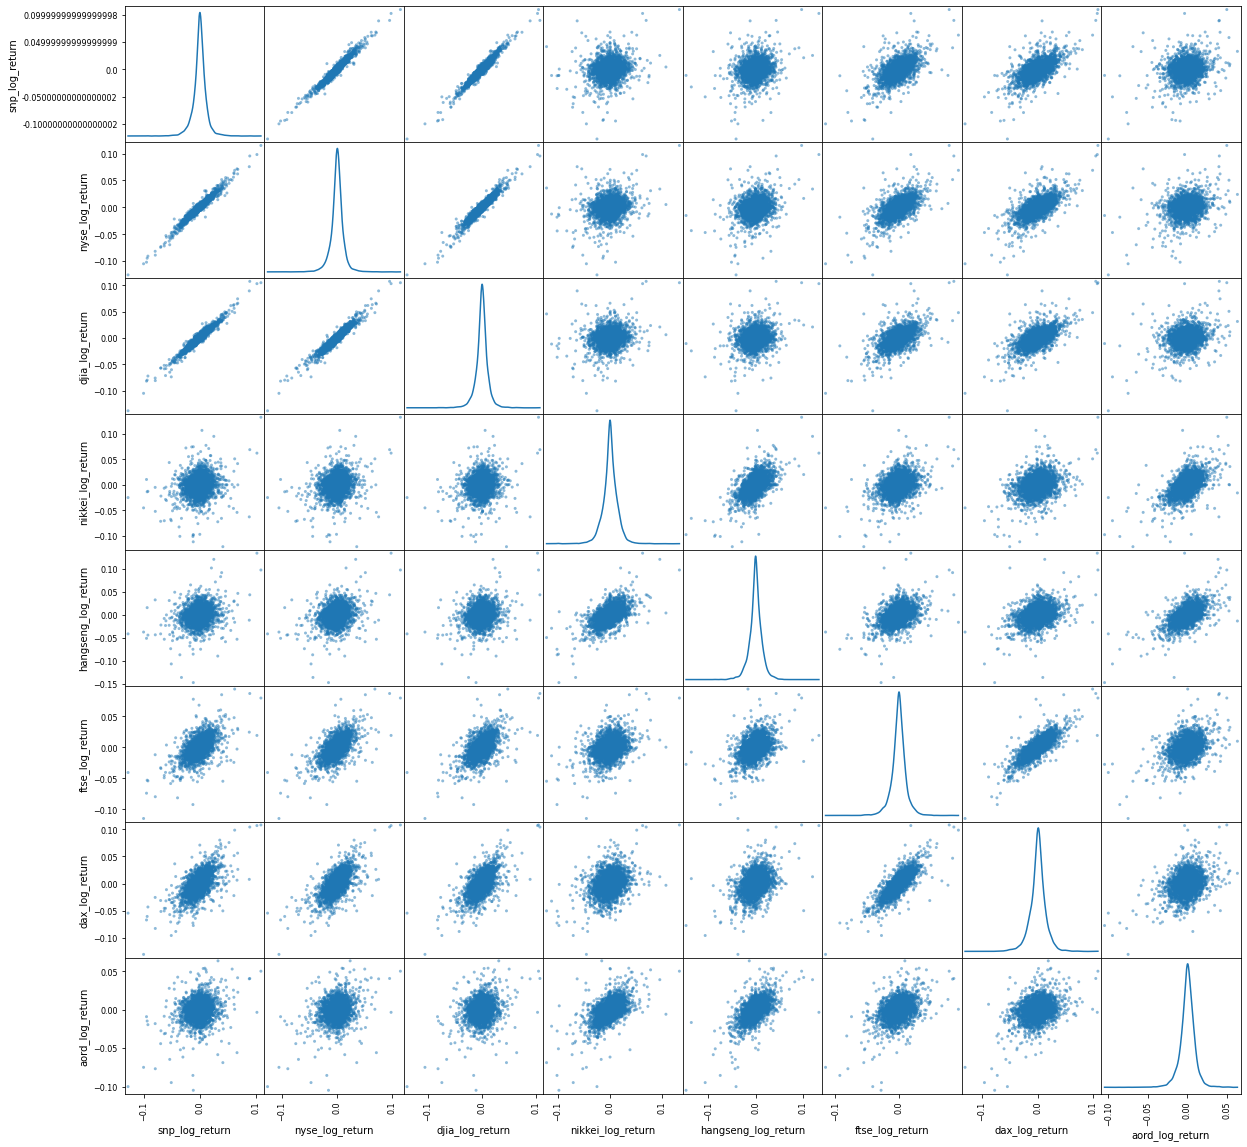

In [13]:
_ = scatter_matrix(log_return_data, figsize=(20, 20), diagonal='kde')

The story with the previous scatter plot for log returns is more subtle and more interesting. The US indices are strongly correlated, as expected. The other indices, less so, which is also expected. But there is structure and signal there. Now let's move forward and start to quantify it so we can start to choose features for our model.
First look at how the log returns for the closing value of the S&P 500 correlate with the closing values of other indices available on the same day. This essentially means to assume the indices that close before the S&P 500 (non-US indices) are available and the others (US indices) are not.

In [14]:
tmp = pd.DataFrame()
tmp['snp_0'] = log_return_data['snp_log_return']
tmp['nyse_1'] = log_return_data['nyse_log_return'].shift()
tmp['djia_1'] = log_return_data['djia_log_return'].shift()
tmp['ftse_0'] = log_return_data['ftse_log_return']
tmp['dax_0'] = log_return_data['dax_log_return']
tmp['hangseng_0'] = log_return_data['hangseng_log_return']
tmp['nikkei_0'] = log_return_data['nikkei_log_return']
tmp['aord_0'] = log_return_data['aord_log_return']
tmp.corr().iloc[:,0]

snp_0         1.000000
nyse_1       -0.109618
djia_1       -0.112204
ftse_0        0.560371
dax_0         0.613149
hangseng_0    0.224812
nikkei_0      0.176385
aord_0        0.206016
Name: snp_0, dtype: float64

Here, we are directly working based on the working hypothesis. We're correlating the close of the S&P 500 with signals available before the close of the S&P 500. We see that the S&P 500 close is correlated with European indices at around 0.56 for FTSE, 0.61 for DAX, which is a strong correlation, and Asian/Oceanian indices at around 0.17-0.22, which is a significant correlation, but not with US indices. We have available signals from other indices and regions for our model.

Now look at how the log returns for the S&P closing values correlate with index values from the previous day to see if the previous closing is predictive. Following from the hypothesis that financial markets are Markov processes, there should be little or no value in historical values.

In [15]:
tmp = pd.DataFrame()
tmp['snp_0'] = log_return_data['snp_log_return']
tmp['nyse_1'] = log_return_data['nyse_log_return'].shift(2)
tmp['djia_1'] = log_return_data['djia_log_return'].shift(2)
tmp['ftse_0'] = log_return_data['ftse_log_return'].shift()
tmp['dax_0'] = log_return_data['dax_log_return'].shift()
tmp['hangseng_0'] = log_return_data['hangseng_log_return'].shift()
tmp['nikkei_0'] = log_return_data['nikkei_log_return'].shift()
tmp['aord_0'] = log_return_data['aord_log_return'].shift()
tmp.corr().iloc[:,0]

snp_0         1.000000
nyse_1        0.001059
djia_1        0.002381
ftse_0       -0.073399
dax_0        -0.052146
hangseng_0   -0.038335
nikkei_0     -0.002728
aord_0       -0.056955
Name: snp_0, dtype: float64

We should see little to no correlation in this data, meaning that yesterday's values are no practical help in predicting today's close. Let's go one step further and look at correlations between today and the the day before yesterday.

In [16]:
tmp = pd.DataFrame()
tmp['snp_0'] = log_return_data['snp_log_return']
tmp['nyse_1'] = log_return_data['nyse_log_return'].shift(3)
tmp['djia_1'] = log_return_data['djia_log_return'].shift(3)
tmp['ftse_0'] = log_return_data['ftse_log_return'].shift(2)
tmp['dax_0'] = log_return_data['dax_log_return'].shift(2)
tmp['hangseng_0'] = log_return_data['hangseng_log_return'].shift(2)
tmp['nikkei_0'] = log_return_data['nikkei_log_return'].shift(2)
tmp['aord_0'] = log_return_data['aord_log_return'].shift(2)

tmp.corr().iloc[:,0]

snp_0         1.000000
nyse_1        0.017791
djia_1        0.019113
ftse_0        0.021976
dax_0         0.029924
hangseng_0    0.007603
nikkei_0     -0.019350
aord_0        0.021364
Name: snp_0, dtype: float64

Again, there are little to no correlations.
<h3>Summing up the EDA</h3>
At this point, we've done a good enough job of exploratory data analysis. We have visualized the data and come to know it better. We have transformed it into a form that is useful for modelling, log returns, and looked at how indices relate to each other. We have seen that indices from Europe strongly correlate with US indices, and that indices from Asia/Oceania significantly correlate with those same indices for a given day. We've also seen that if we look at historical values, they do not correlate with today's values. Summing up:
<ul>
<li>European indices from the same day were a strong predictor for the S&P 500 close.
<li>Asian/Oceanian indices from the same day were a significant predictor for the S&P 500 close.
<li>Indices from previous days were not good predictors for the S&P close.
</ul>

<h3>Feature selection</h3>
At this point, we can see a model:
<ul>
<li>We'll predict whether the S&P 500 close today will be higher or lower than yesterday.
<li>We'll use all our data sources: NYSE, DJIA, Nikkei, Hang Seng, FTSE, DAX, AORD.
<li>We'll use three sets of data points — $T$, $T-1$, and $T-2$ — where we take the data available on day $T$ or $T-n$, meaning today's non-US data and yesterday's US data.
</ul>

Predicting whether the log return of the S&P 500 is positive or negative is a classification problem. That is, we want to choose one option from a finite set of options, in this case positive or negative. This is the base case of classification where we have only two values to choose from, known as binary classification, or logistic regression.

This uses the findings from of our exploratory data analysis, namely that log returns from other regions on a given day are strongly correlated with the log return of the S&P 500, and there are stronger correlations from those regions that are geographically closer with respect to time zones. However, our models also use data outside of those findings. For example, we use data from the past few days in addition to today. There are two reasons for using this additional data. First, we're adding additional features to our model for the purpose of this solution to see how things perform (which is of course not a good reason for adding features outside of a tutorial setting). Second, machine learning models are very good at finding weak signals from data.

In machine learning, as in most things, there are subtle tradeoffs happening, but in general good data is better than good algorithms, which are better than good frameworks. We need all three pillars but in that order of importance: data, algorithms, frameworks.

<h3>TensorFlow</h3>

We discussed TensorFlow in the previous lab session. It is an open source software library, initiated by Google, for numerical computation using data flow graphs. It is a great framework for machine learning because it is expressive, efficient, and easy to use.
<h4>Feature engineering for TensorFlow</h4>
From a training and testing perspective, time series data is easy. Training data should come from events that happened before test data events, and be contiguous in time. Otherwise, our model would be trained on events from "the future", at least as compared to the test data. It would then likely perform badly in practice, because we can’t really have access to data from the future. That means random sampling or cross validation don't apply to time series data. Let's decide on a training-versus-testing split, and divide the data into training and test datasets.
In this case, we'll create the features together with two additional columns:
<ul>
<li>snp_log_return_positive, which is 1 if the log return of the S&P 500 close is positive, and 0 otherwise.
<li>snp_log_return_negative, which is 1 if the log return of the S&P 500 close is negative, and 0 otherwise.
</ul>

Now, logically we could encode this information in one column, named snp_log_return, which is 1 if positive and 0 if negative, but we'll prefer a different approach that allows for many different potential values to choose from, and a form or encoding for these options called one-hot encoding. One-hot encoding means that each choice is an entry in an array, and the actual value has an entry of 1 with all other values being 0. This encoding (i.e. a single 1 in an array of 0s) is for the input of the model, where you categorically know which value is correct. A variation of this is used for the output, where each entry in the array contains the probability of the answer being that choice. We can then choose the most likely value by choosing the highest probability, together with having a measure of the confidence we can place in that answer relative to other answers.

We'll use 80% of our data for training and 20% for testing.

In [17]:
log_return_data['snp_log_return_positive'] = 0
log_return_data.loc[log_return_data['snp_log_return'] >= 0, 'snp_log_return_positive'] = 1
log_return_data['snp_log_return_negative'] = 0
log_return_data.loc[log_return_data['snp_log_return'] < 0, 'snp_log_return_negative'] = 1

training_test_data = pd.DataFrame(
  columns=[
    'snp_log_return_positive', 'snp_log_return_negative',
    'snp_log_return_1', 'snp_log_return_2', 'snp_log_return_3',
    'nyse_log_return_1', 'nyse_log_return_2', 'nyse_log_return_3',
    'djia_log_return_1', 'djia_log_return_2', 'djia_log_return_3',
    'nikkei_log_return_0', 'nikkei_log_return_1', 'nikkei_log_return_2',
    'hangseng_log_return_0', 'hangseng_log_return_1', 'hangseng_log_return_2',
    'ftse_log_return_0', 'ftse_log_return_1', 'ftse_log_return_2',
    'dax_log_return_0', 'dax_log_return_1', 'dax_log_return_2',
    'aord_log_return_0', 'aord_log_return_1', 'aord_log_return_2'])

for i in range(7, len(log_return_data)):
  snp_log_return_positive = log_return_data['snp_log_return_positive'].iloc[i]
  snp_log_return_negative = log_return_data['snp_log_return_negative'].iloc[i]
  snp_log_return_1 = log_return_data['snp_log_return'].iloc[i-1]
  snp_log_return_2 = log_return_data['snp_log_return'].iloc[i-2]
  snp_log_return_3 = log_return_data['snp_log_return'].iloc[i-3]
  nyse_log_return_1 = log_return_data['nyse_log_return'].iloc[i-1]
  nyse_log_return_2 = log_return_data['nyse_log_return'].iloc[i-2]
  nyse_log_return_3 = log_return_data['nyse_log_return'].iloc[i-3]
  djia_log_return_1 = log_return_data['djia_log_return'].iloc[i-1]
  djia_log_return_2 = log_return_data['djia_log_return'].iloc[i-2]
  djia_log_return_3 = log_return_data['djia_log_return'].iloc[i-3]
  nikkei_log_return_0 = log_return_data['nikkei_log_return'].iloc[i]
  nikkei_log_return_1 = log_return_data['nikkei_log_return'].iloc[i-1]
  nikkei_log_return_2 = log_return_data['nikkei_log_return'].iloc[i-2]
  hangseng_log_return_0 = log_return_data['hangseng_log_return'].iloc[i]
  hangseng_log_return_1 = log_return_data['hangseng_log_return'].iloc[i-1]
  hangseng_log_return_2 = log_return_data['hangseng_log_return'].iloc[i-2]
  ftse_log_return_0 = log_return_data['ftse_log_return'].iloc[i]
  ftse_log_return_1 = log_return_data['ftse_log_return'].iloc[i-1]
  ftse_log_return_2 = log_return_data['ftse_log_return'].iloc[i-2]
  dax_log_return_0 = log_return_data['dax_log_return'].iloc[i]
  dax_log_return_1 = log_return_data['dax_log_return'].iloc[i-1]
  dax_log_return_2 = log_return_data['dax_log_return'].iloc[i-2]
  aord_log_return_0 = log_return_data['aord_log_return'].iloc[i]
  aord_log_return_1 = log_return_data['aord_log_return'].iloc[i-1]
  aord_log_return_2 = log_return_data['aord_log_return'].iloc[i-2]
  training_test_data = training_test_data.append(
    {'snp_log_return_positive':snp_log_return_positive,
    'snp_log_return_negative':snp_log_return_negative,
    'snp_log_return_1':snp_log_return_1,
    'snp_log_return_2':snp_log_return_2,
    'snp_log_return_3':snp_log_return_3,
    'nyse_log_return_1':nyse_log_return_1,
    'nyse_log_return_2':nyse_log_return_2,
    'nyse_log_return_3':nyse_log_return_3,
    'djia_log_return_1':djia_log_return_1,
    'djia_log_return_2':djia_log_return_2,
    'djia_log_return_3':djia_log_return_3,
    'nikkei_log_return_0':nikkei_log_return_0,
    'nikkei_log_return_1':nikkei_log_return_1,
    'nikkei_log_return_2':nikkei_log_return_2,
    'hangseng_log_return_0':hangseng_log_return_0,
    'hangseng_log_return_1':hangseng_log_return_1,
    'hangseng_log_return_2':hangseng_log_return_2,
    'ftse_log_return_0':ftse_log_return_0,
    'ftse_log_return_1':ftse_log_return_1,
    'ftse_log_return_2':ftse_log_return_2,
    'dax_log_return_0':dax_log_return_0,
    'dax_log_return_1':dax_log_return_1,
    'dax_log_return_2':dax_log_return_2,
    'aord_log_return_0':aord_log_return_0,
    'aord_log_return_1':aord_log_return_1,
    'aord_log_return_2':aord_log_return_2},
    ignore_index=True)
  
training_test_data.describe()

,snp_log_return_positive,snp_log_return_negative,snp_log_return_1,snp_log_return_2,snp_log_return_3,nyse_log_return_1,nyse_log_return_2,nyse_log_return_3,djia_log_return_1,djia_log_return_2,...,hangseng_log_return_2,ftse_log_return_0,ftse_log_return_1,ftse_log_return_2,dax_log_return_0,dax_log_return_1,dax_log_return_2,aord_log_return_0,aord_log_return_1,aord_log_return_2
count,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,...,5276.000000,5276.000000,5.276000e+03,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000
mean,0.537528,0.462472,0.000178,0.000180,0.000184,0.000141,0.000142,0.000147,0.000183,0.000184,...,0.000101,0.000001,-1.434704e-07,0.000003,0.000130,0.000130,0.000135,0.000149,0.000153,0.000157
std,0.498637,0.498637,0.012543,0.012544,0.012548,0.012459,0.012460,0.012464,0.012071,0.012071,...,0.014463,0.011969,1.197030e-02,0.011972,0.014984,0.014984,0.014987,0.010109,0.010113,0.010116
min,0.000000,0.000000,-0.127652,-0.127652,-0.127652,-0.125950,-0.125950,-0.125950,-0.138418,-0.138418,...,-0.146954,-0.115117,-1.151171e-01,-0.115117,-0.130549,-0.130549,-0.130549,-0.104874,-0.104874,-0.104874
25%,0.000000,0.000000,-0.004779,-0.004779,-0.004779,-0.004662,-0.004662,-0.004662,-0.004619,-0.004619,...,-0.006286,-0.005259,-5.259264e-03,-0.005259,-0.006600,-0.006600,-0.006600,-0.004272,-0.004272,-0.004272
50%,1.000000,0.000000,0.000590,0.000593,0.000593,0.000630,0.000631,0.000631,0.000498,0.000502,...,0.000000,0.000028,2.827272e-05,0.000031,0.000576,0.000576,0.000579,0.000407,0.000410,0.000419
75%,1.000000,1.000000,0.005801,0.005805,0.005805,0.005678,0.005684,0.005687,0.005584,0.005584,...,0.007032,0.005737,5.737253e-03,0.005743,0.007384,0.007384,0.007391,0.005226,0.005230,0.005241
max,1.000000,1.000000,0.109572,0.109572,0.109572,0.115258,0.115258,0.115258,0.107643,0.107643,...,0.134068,0.093842,9.384244e-02,0.093842,0.107975,0.107975,0.107975,0.063548,0.063548,0.063548


Now, create the training and test data.

In [18]:
predictors_tf = training_test_data[training_test_data.columns[2:]]

classes_tf = training_test_data[training_test_data.columns[:2]]

training_set_size = int(len(training_test_data) * 0.8)
test_set_size = len(training_test_data) - training_set_size

training_predictors = predictors_tf[:training_set_size]
training_classes = classes_tf[:training_set_size]
test_predictors = predictors_tf[training_set_size:]
test_classes = classes_tf[training_set_size:]

training_predictors.describe()

,snp_log_return_1,snp_log_return_2,snp_log_return_3,nyse_log_return_1,nyse_log_return_2,nyse_log_return_3,djia_log_return_1,djia_log_return_2,djia_log_return_3,nikkei_log_return_0,...,hangseng_log_return_2,ftse_log_return_0,ftse_log_return_1,ftse_log_return_2,dax_log_return_0,dax_log_return_1,dax_log_return_2,aord_log_return_0,aord_log_return_1,aord_log_return_2
count,4220.000000,4220.000000,4220.000000,4220.000000,4220.000000,4220.000000,4220.000000,4220.000000,4220.000000,4220.000000,...,4220.000000,4220.000000,4220.000000,4220.000000,4220.000000,4220.000000,4220.000000,4220.000000,4220.000000,4220.000000
mean,0.000091,0.000092,0.000099,0.000103,0.000103,0.000109,0.000107,0.000107,0.000113,-0.000025,...,0.000095,0.000014,0.000011,0.000015,0.000103,0.000102,0.000104,0.000132,0.000135,0.000139
std,0.012495,0.012496,0.012503,0.012472,0.012471,0.012477,0.011705,0.011705,0.011710,0.015524,...,0.015163,0.012206,0.012208,0.012210,0.015511,0.015511,0.015513,0.009930,0.009934,0.009938
min,-0.094695,-0.094695,-0.094695,-0.102321,-0.102321,-0.102321,-0.082005,-0.082005,-0.082005,-0.121110,...,-0.146954,-0.092646,-0.092646,-0.092646,-0.095756,-0.095756,-0.095756,-0.104874,-0.104874,-0.104874
25%,-0.005368,-0.005368,-0.005368,-0.005201,-0.005201,-0.005201,-0.005042,-0.005042,-0.005042,-0.007384,...,-0.006561,-0.005503,-0.005513,-0.005513,-0.007381,-0.007381,-0.007381,-0.004485,-0.004485,-0.004485
50%,0.000488,0.000488,0.000497,0.000580,0.000580,0.000589,0.000438,0.000438,0.000441,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000610,0.000604,0.000604,0.000362,0.000362,0.000362
75%,0.005880,0.005880,0.005892,0.005896,0.005896,0.005907,0.005675,0.005675,0.005685,0.008186,...,0.007319,0.005938,0.005938,0.005946,0.007785,0.007785,0.007785,0.005362,0.005384,0.005394
max,0.109572,0.109572,0.109572,0.115258,0.115258,0.115258,0.105083,0.105083,0.105083,0.132346,...,0.134068,0.093842,0.093842,0.093842,0.107975,0.107975,0.107975,0.054010,0.054010,0.054010


In [19]:
test_predictors.describe()

,snp_log_return_1,snp_log_return_2,snp_log_return_3,nyse_log_return_1,nyse_log_return_2,nyse_log_return_3,djia_log_return_1,djia_log_return_2,djia_log_return_3,nikkei_log_return_0,...,hangseng_log_return_2,ftse_log_return_0,ftse_log_return_1,ftse_log_return_2,dax_log_return_0,dax_log_return_1,dax_log_return_2,aord_log_return_0,aord_log_return_1,aord_log_return_2
count,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,...,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000
mean,0.000526,0.000533,0.000522,0.000293,0.000300,0.000296,0.000486,0.000492,0.000483,0.000454,...,0.000126,-0.000051,-0.000044,-0.000044,0.000240,0.000244,0.000258,0.000217,0.000225,0.000228
std,0.012730,0.012731,0.012729,0.012416,0.012418,0.012418,0.013439,0.013439,0.013438,0.011653,...,0.011246,0.010979,0.010977,0.010977,0.012669,0.012668,0.012673,0.010800,0.010801,0.010801
min,-0.127652,-0.127652,-0.127652,-0.125950,-0.125950,-0.125950,-0.138418,-0.138418,-0.138418,-0.062736,...,-0.057202,-0.115117,-0.115117,-0.115117,-0.130549,-0.130549,-0.130549,-0.100094,-0.100094,-0.100094
25%,-0.002867,-0.002867,-0.002895,-0.002923,-0.002923,-0.002923,-0.003111,-0.003111,-0.003111,-0.004431,...,-0.005226,-0.004502,-0.004458,-0.004458,-0.004392,-0.004392,-0.004392,-0.003554,-0.003554,-0.003554
50%,0.000779,0.000795,0.000779,0.000723,0.000729,0.000723,0.000970,0.000974,0.000970,0.000000,...,0.000320,0.000380,0.000380,0.000380,0.000444,0.000495,0.000532,0.000663,0.000668,0.000675
75%,0.005426,0.005510,0.005426,0.005031,0.005080,0.005080,0.005228,0.005228,0.005195,0.005522,...,0.005914,0.004934,0.004934,0.004934,0.005683,0.005683,0.005688,0.004841,0.004841,0.004841
max,0.089683,0.089683,0.089683,0.095642,0.095642,0.095642,0.107643,0.107643,0.107643,0.077314,...,0.049250,0.086664,0.086664,0.086664,0.104143,0.104143,0.104143,0.063548,0.063548,0.063548


Define some metrics here to evaluate the models.
<ul>
<li>Precision - The ability of the classifier not to label as positive a sample that is negative.
<li>Recall - The ability of the classifier to find all the positive samples.
<li>F1 Score - A weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.
<li>Accuracy - The percentage correctly predicted in the test data.
</ul>

In [20]:
def tf_confusion_metrics(predicted_classes, actual_classes):
  predictions = tf.argmax(predicted_classes, 1)
  actuals = tf.argmax(actual_classes, 1)

  ones_like_actuals = tf.ones_like(actuals)
  zeros_like_actuals = tf.zeros_like(actuals)
  ones_like_predictions = tf.ones_like(predictions)
  zeros_like_predictions = tf.zeros_like(predictions)

  #true positive  
  tp_op = tf.reduce_sum(
    tf.cast(
      tf.logical_and(
        tf.equal(actuals, ones_like_actuals), 
        tf.equal(predictions, ones_like_predictions)
      ), 
      "float"
    )
  )

  #true negative  
  tn_op = tf.reduce_sum(
    tf.cast(
      tf.logical_and(
        tf.equal(actuals, zeros_like_actuals), 
        tf.equal(predictions, zeros_like_predictions)
      ), 
      "float"
    )
  )

  #false positive  
  fp_op = tf.reduce_sum(
    tf.cast(
      tf.logical_and(
        tf.equal(actuals, zeros_like_actuals), 
        tf.equal(predictions, ones_like_predictions)
      ), 
      "float"
    )
  )

  #false negative  
  fn_op = tf.reduce_sum(
    tf.cast(
      tf.logical_and(
        tf.equal(actuals, ones_like_actuals), 
        tf.equal(predictions, zeros_like_predictions)
      ), 
      "float"
    )
  )

  tpr = float(tp_op)/(float(tp_op) + float(fn_op))
  fpr = float(fp_op)/(float(fp_op) + float(tn_op))

  accuracy = (float(tp_op) + float(tn_op))/(float(tp_op) + float(fp_op) + float(fn_op) + float(tn_op))

  recall = tpr
  precision = float(tp_op)/(float(tp_op) + float(fp_op))
  
  f1_score = (2 * (precision * recall)) / (precision + recall)
  
  print('Precision = ', precision)
  print('Recall = ', recall)
  print('F1 Score = ', f1_score)
  print('Accuracy = ', accuracy)

<h3>Binary classification with TensorFlow</h3>

Now, get some action on the tensors. The model is binary classification expressed in TensorFlow.

In [21]:
# Define variables for the number of predictors and number of classes 
num_predictors = len(training_predictors.columns) # 24 in the default case
num_classes = len(training_classes.columns) # 2 in the default case

# Define a matrix of weights and initialize it with some small random values.
weights = tf.Variable(tf.cast(tf.random.truncated_normal([num_predictors, num_classes], stddev=0.0001), double))
biases = tf.Variable(tf.cast(tf.ones([num_classes]), double))

# Define our model
# Here we take a softmax regression of the product of our feature data and weights
def bin_classify(train_data):
    return tf.nn.softmax(tf.matmul(train_data.values, weights) + biases)

# Define a cost function (we're using the cross entropy)
def cost(labeled_data, train_data):
    loss = -tf.reduce_sum(labeled_data.values.reshape(len(training_classes), 2)*tf.math.log(train_data))
    return loss

# Here we use gradient descent with a learning rate of 0.01 using the cost function we just defined
optimizer = tf.optimizers.Adam(learning_rate=0.01)

We'll train our model in the following snippet. We'll train the model over 10,000 iterations using the full training dataset each time. Every 2000 iterations, we'll assess the accuracy of the model on the training data to assess progress.

In [22]:
# Optimization process. This extends the linear regression example seen in the previous lab session.
def run_optimization():
    # Wrap computation inside a GradientTape for automatic differentiation
    with tf.GradientTape() as g:
        predicted_classes = bin_classify(training_predictors)
        loss = cost(training_classes, predicted_classes)
    
    vars = [weights, biases]
    # Compute gradients. Since we have two variables, we get two gradients
    gradients = g.gradient(loss, vars)
    
    # Update weights and biases following gradients. What does zip do? Can you figure it out?
    optimizer.apply_gradients(zip(gradients, vars))

In [23]:
actual = training_classes.values.reshape(len(training_classes.values), 2)

for i in range(1, 10001):
    run_optimization()
    if i%2000 == 0:
        predicted = bin_classify(training_predictors)
        correct_prediction = tf.equal(tf.argmax(predicted, 1), tf.argmax(actual, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print('Iteration:', i, "Accuracy:", accuracy.numpy())

Iteration: 2000 Accuracy: 0.7149289
Iteration: 4000 Accuracy: 0.71966827
Iteration: 6000 Accuracy: 0.7220379
Iteration: 8000 Accuracy: 0.7225118
Iteration: 10000 Accuracy: 0.7222749


An accuracy of 72% on the training data is certainly fine and far better than random.

It is now time to apply the weights and the biases on the test data. 

In [24]:
# Let's see what we predict for the test data
predicted_test = bin_classify(test_predictors)
actual_test = test_classes.values

In [25]:
# Time to obtain some metrics, see above for the definition of tf_confusion_metrics
tf_confusion_metrics(predicted_test, actual_test)

Precision =  0.6742081447963801
Recall =  0.645021645021645
F1 Score =  0.6592920353982301
Accuracy =  0.7083333333333334


<h3> Binary Classification with Keras and a feed-forward neural network </h3>

Let's now follow a different approach and build a proper feed-forward neural net with two hidden layers. Again, we'll train the model over a number of epochs using the full training dataset each time. 

We first define the layers. The first two have 20 nodes each and use the ReLU activation function. The output layer uses a softmax activation function. Don't worry if these notions seem entirely new; they probably are. We will cover them in the next lectures in more details.

In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [27]:
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
# we now get rid of the one-hot encoding user earlier.
# as the label data consist of two columns, we simply select the second column as the correct label.
# indeed, a label of [0] [1] in one-hot encoding implies that the input belongs in the second category.
# Then, it belongs in category 1 (important: category 0 is the first). Similarly, a label of [1][0] implies
# that the input belongs in the first category. In any case, the second value in the one-hot encoding provides
# the correct category. Important: This property does not hold in general, but only since we have two classes

modified_classes = training_classes["snp_log_return_negative"]
modified_test_classes = test_classes["snp_log_return_negative"]

In [29]:
model.fit(training_predictors, modified_classes, epochs=20)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


132/132 [==============================] - 1s 2ms/step - loss: 0.6859 - accuracy: 0.5645
Epoch 2/20
132/132 [==============================] - 0s 2ms/step - loss: 0.6591 - accuracy: 0.6659
Epoch 3/20
132/132 [==============================] - 0s 2ms/step - loss: 0.6107 - accuracy: 0.6903
Epoch 4/20
132/132 [==============================] - 0s 2ms/step - loss: 0.5790 - accuracy: 0.7000
Epoch 5/20
132/132 [==============================] - 0s 2ms/step - loss: 0.5676 - accuracy: 0.7135
Epoch 6/20
132/132 [==============================] - 0s 2ms/step - loss: 0.5629 - accuracy: 0.7175
Epoch 7/20
132/132 [==============================] - 0s 2ms/step - loss: 0.5610 - accuracy: 0.7078
Epoch 8/20
132/132 [==============================] - 1s 4ms/step - loss: 0.5579 - accuracy: 0.7135
Epoch 9/20
132/132 [==============================] - 1s 5ms/step - loss: 0.5578 - accuracy: 0.7199
Epoch 10/20
132/132 [==============================] - 0s 2ms/step - loss: 0.5562 - accuracy: 0.7149
Epoch 11/2

In [30]:
test_loss, test_acc = model.evaluate(test_predictors,  modified_test_classes, verbose=2)

print('\nTest accuracy:', test_acc)

33/33 - 0s - loss: 0.5657 - accuracy: 0.7083 - 186ms/epoch - 6ms/step

Test accuracy: 0.7083333134651184


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


<h3>Follow-up work</h3>
<ul>
<li>What would change if we used the most recent 5 years of data?</li>
<li>Can you try a similar approach with different data (e.g., currencies)?</li>
</ul>